# Linear basis function models with PyMC3

In [1]:
import logging
import pymc3 as pm
import numpy as np

print(pm.__version__)

3.8


This is a [PyMC3](https://docs.pymc.io/) implementation of the examples in [Bayesian regression with linear basis function models](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/bayesian_linear_regression.ipynb). To recap, a linear regression model is a linear function of the parameters but not necessarily of the input. Input $x$ can be expanded with a set of non-linear basis functions $\phi_j(x)$, where $(\phi_1(x), \dots, \phi_M(x))^T = \boldsymbol\phi(x)$, for modeling a non-linear relationship between input $x$ and a function value $y$.

$$
y(x, \mathbf{w}) = w_0 + \sum_{j=1}^{M}{w_j \phi_j(x)} = w_0 + \mathbf{w}_{1:}^T \boldsymbol\phi(x) \tag{1}
$$

For simplicity I'm using a scalar input $x$ here. Target variable $t$ is given by the deterministic function $y(x, \mathbf{w})$ and Gaussian noise $\epsilon$.

$$
t = y(x, \mathbf{w}) + \epsilon \tag{2}
$$

Here, we can choose between polynomial and Gaussian basis functions for expanding input $x$. 

In [2]:
from functools import partial
from scipy.stats import norm

def polynomial_basis(x, power):
    return x ** power

def gaussian_basis(x, mu, sigma):
    return norm(loc=mu, scale=sigma).pdf(x).astype(np.float32)

def _expand(x, bf, bf_args):
    return np.stack([bf(x, bf_arg) for bf_arg in bf_args], axis=1)

def expand_polynomial(x, degree=3):
    return _expand(x, bf=polynomial_basis, bf_args=range(1, degree + 1))

def expand_gaussian(x, mus=np.linspace(0, 1, 9), sigma=0.3):
    return _expand(x, bf=partial(gaussian_basis, sigma=sigma), bf_args=mus)

# Choose between polynomial and Gaussian expansion
# (by switching the comment on the following two lines)
expand = expand_polynomial
#expand = expand_gaussian

For example, to expand two input values `[0.5, 1.5]` into a polynomial design matrix of degree `3` we can use

In [3]:
expand_polynomial(np.array([0.5, 1.5]), degree=3)

array([[0.5  , 0.25 , 0.125],
       [1.5  , 2.25 , 3.375]])

The power of `0` is omitted here and covered by a $w_0$ in the model.

## Example dataset

The example dataset consists of `N` noisy samples from a sinusoidal function `f`.

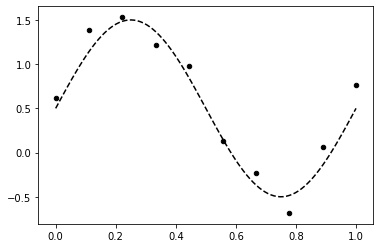

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from bayesian_linear_regression_util import (
    plot_data, 
    plot_truth
)

def f(x, noise=0):
    """Sinusoidal function with optional Gaussian noise."""
    return 0.5 + np.sin(2 * np.pi * x) + np.random.normal(scale=noise, size=x.shape)

# Number of samples
N = 10

# Constant noise 
noise = 0.3

# Noisy samples 
x = np.linspace(0, 1, N, dtype=np.float32)
t = f(x, noise=noise)

# Noise-free ground truth 
x_test = np.linspace(0, 1, 100).astype(np.float32)
y_true = f(x_test)

plot_data(x, t)
plot_truth(x_test, y_true)

## Implementation with PyMC3

### Model definition

The model definition directly follows from Eq. $(1)$ and Eq. $(2)$ with normal priors over parameters. The size of parameter vector `w_r` ($\mathbf{w}_{1:}$ in Eq. $(1)$) is determined by the number of basis functions. With the above default settings, it is 3 for polynomial expansion and 9 for Gaussian expansion.

In [5]:
from theano import shared

Phi = expand(x)
Phi_shared = shared(Phi)

with pm.Model() as model:
    w_0 = pm.Normal('w_0', mu=0, sigma=10)
    w_r = pm.Normal('w_r', mu=0, sigma=10, shape=Phi.shape[1])

    mu = w_0 + w_r.dot(Phi_shared.T)
    
    t_obs = pm.Normal('t_obs', mu=mu, sigma=noise, observed=t)

### Inference

In [6]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [w_r, w_0]
Sampling 3 chains, 0 divergences: 100%|██████████| 3000/3000 [00:05<00:00, 528.69draws/s]
The number of effective samples is smaller than 25% for some parameters.


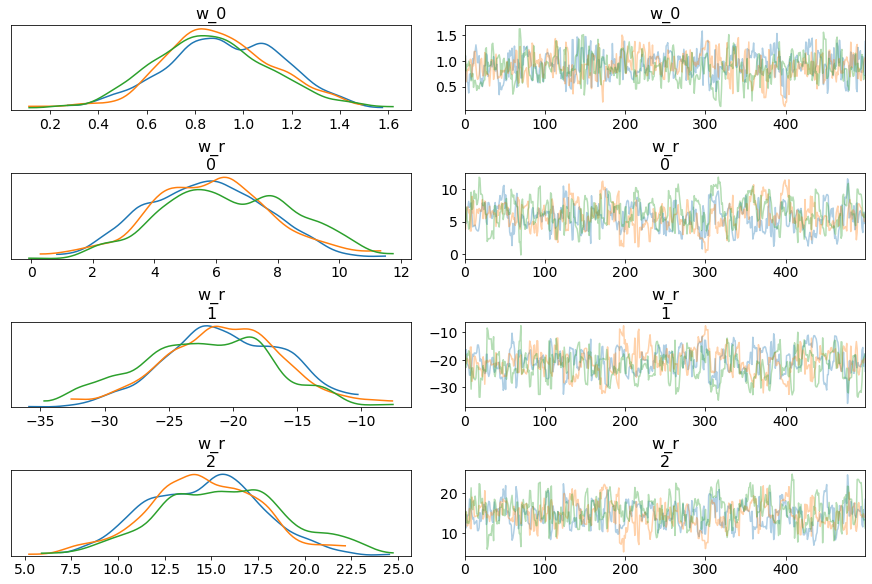

In [7]:
pm.traceplot(trace, compact=False);

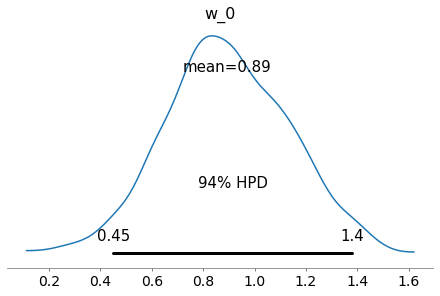

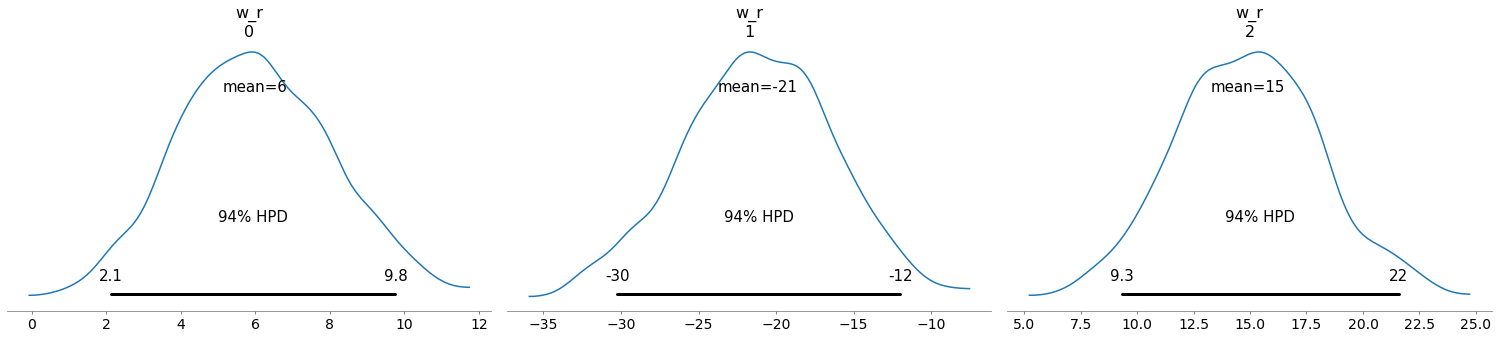

In [8]:
pm.plot_posterior(trace, var_names="w_0")
pm.plot_posterior(trace, var_names="w_r");

### Prediction

We want posterior predictive samples for a separate test set `x_test`. This requires to update the shared input variable `Phi_shared` accordingly.

In [9]:
Phi_shared.set_value(expand(x_test))
predictive_samples = pm.sample_posterior_predictive(trace, model=model, samples=5000)['t_obs']

100%|██████████| 5000/5000 [00:05<00:00, 870.65it/s]


Mean and standard deviation of predictive samples can be used to plot model predictions and their uncertainties (together with the ground truth and the noisy training dataset).

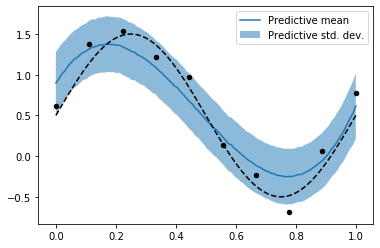

In [10]:
m = np.mean(predictive_samples, axis=0)
s = np.std(predictive_samples, axis=0)

plt.fill_between(x_test, m + s, m - s, alpha = 0.5, label='Predictive std. dev.')
plt.plot(x_test, m, label='Predictive mean');

plot_data(x, t)
plot_truth(x_test, y_true, label=None)

plt.legend();

Try running the example again with Gaussian expansion i.e. setting `expand = expand_gaussian` and see how it compares to polynomial expansion. Also try running with a different number of basis functions by overriding the default arguments of `expand_polynomial` and `expand_gaussian`.